In [11]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import itertools
import tqdm
import copy


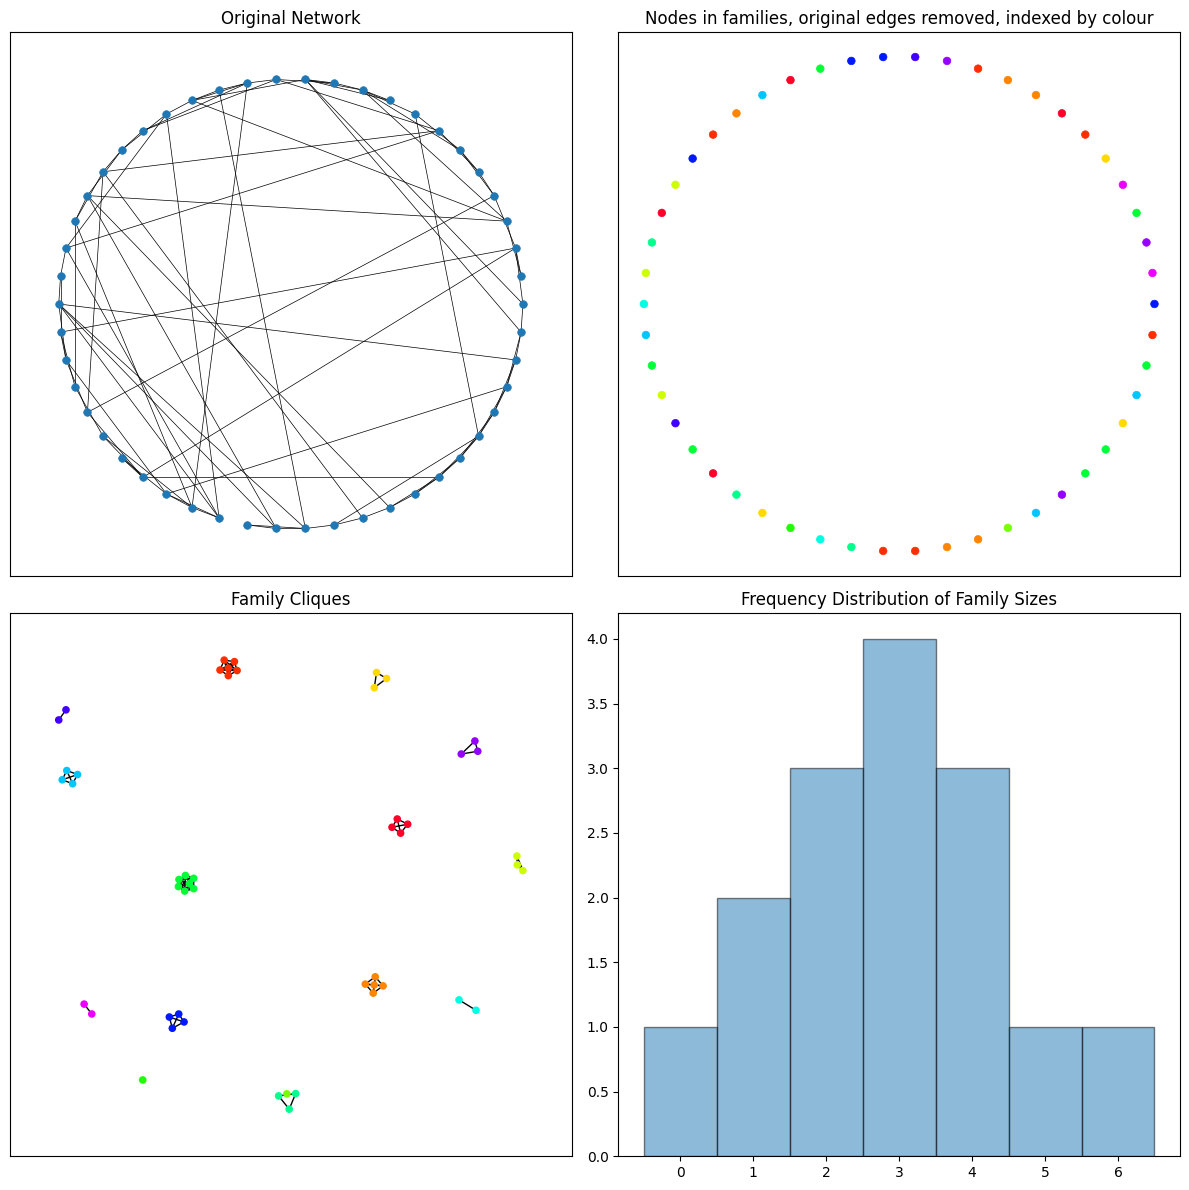

In [179]:
# VARY THESE PARAMETERS
nodes = 50
average_members_in_family = 3

num_fam = int(nodes/average_members_in_family)

# Generate original network
con = 4
g = nx.watts_strogatz_graph(n = nodes, k = con, p = 0.5, seed=None) # can theoretically start this routine with any network
pos = nx.circular_layout(g)

plt.figure(figsize=(12,12))
plt.subplot(221)
nx.draw_networkx(g, pos = pos, with_labels=False, node_size=30, node_color='tab:blue', linewidths=0.5, width = 0.5)
plt.title('Original Network')


# Identify and remove all original existing edges
edges = list(g.edges) 
for i in range(len(list(g.edges))):
    g.remove_edge(u = edges[i][0], v = edges[i][1])

# Group nodes into random clusters
families = [[] for i in range(num_fam)]
dummy_nodes_list = list(g.nodes)

while len(dummy_nodes_list) > 0:
    fam_index = random.randint(0, num_fam-1)
    families[fam_index].append(dummy_nodes_list[-1])
    dummy_nodes_list.remove(dummy_nodes_list[-1])

# print(families) # each list within this list is a family clique, each sublist contains the nodes that belong to that respective family

# Locate which family a certain node is in: this is only for visualisation
def locate_family(node, family_list):
    index = None
    for i in range(len(family_list)):
        if node in family_list[i]:
            index = i
            return index
        else:
            pass
    if index == None:
        print('Node not found in family list.')

# Colour-coding
nodes = list(g.nodes)
familymap = [locate_family(i, families) for i in nodes]
colormap = [cm.gist_rainbow(i/num_fam) for i in familymap]

plt.subplot(222)
nx.draw_networkx(g, pos = pos, with_labels=False, node_size=30, node_color=colormap, linewidths=0.5, width = 0.5)
plt.title('Nodes in families, original edges removed, indexed by colour')


for i in families:
    pairs = list(itertools.combinations(i, 2)) # all combinations, list of edges to generate clique in a family
    # print(families.index(i))
    for p in pairs:
        # print(p)
        g.add_edge(p[0], p[1]) # add all edges in each family clique, all nodes are connected to each other in the clique

plt.subplot(223)
nx.draw_networkx(g, with_labels=False, node_size=20, node_color=colormap, linewidths=1, width = 1)
plt.title('Family Cliques')

# Determine frequency of family sizes
family_sizes = [len(i) for i in families]
# print(family_sizes)

plt.subplot(224)
plt.hist(x = family_sizes, bins = [i-0.5 for i in range(max(family_sizes)+1)], edgecolor = "black", alpha = 0.5, align = 'mid')
plt.title('Frequency Distribution of Family Sizes')

plt.tight_layout()
plt.show()


  0%|                                                    | 0/20 [00:00<?, ?it/s]

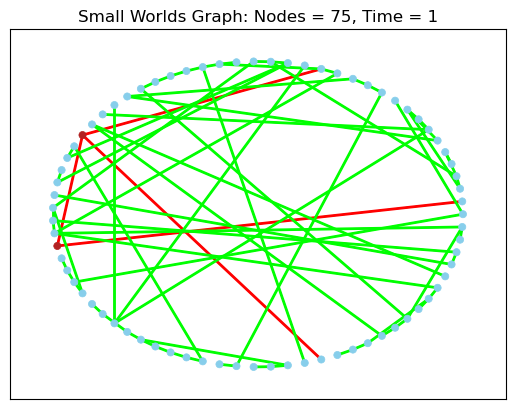

  5%|██▏                                         | 1/20 [00:00<00:02,  8.48it/s]

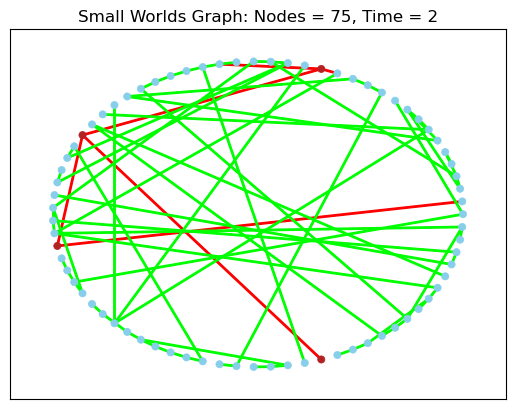

 10%|████▍                                       | 2/20 [00:00<00:02,  8.46it/s]

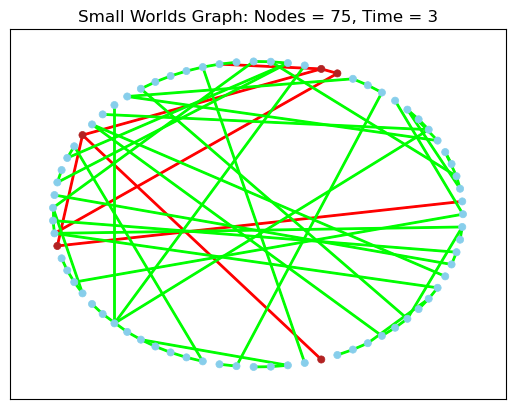

 15%|██████▌                                     | 3/20 [00:00<00:02,  8.44it/s]

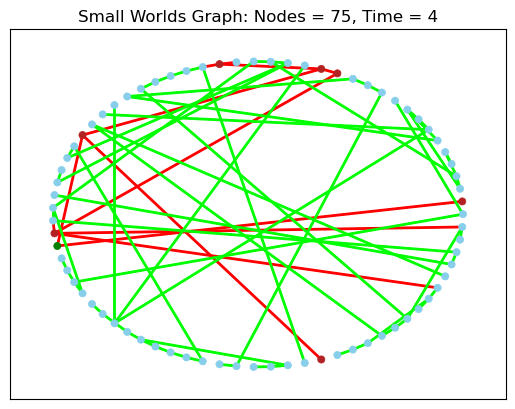

 20%|████████▊                                   | 4/20 [00:00<00:01,  8.44it/s]

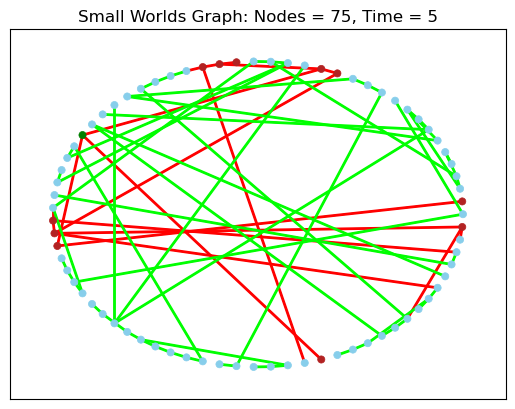

 25%|███████████                                 | 5/20 [00:00<00:01,  8.27it/s]

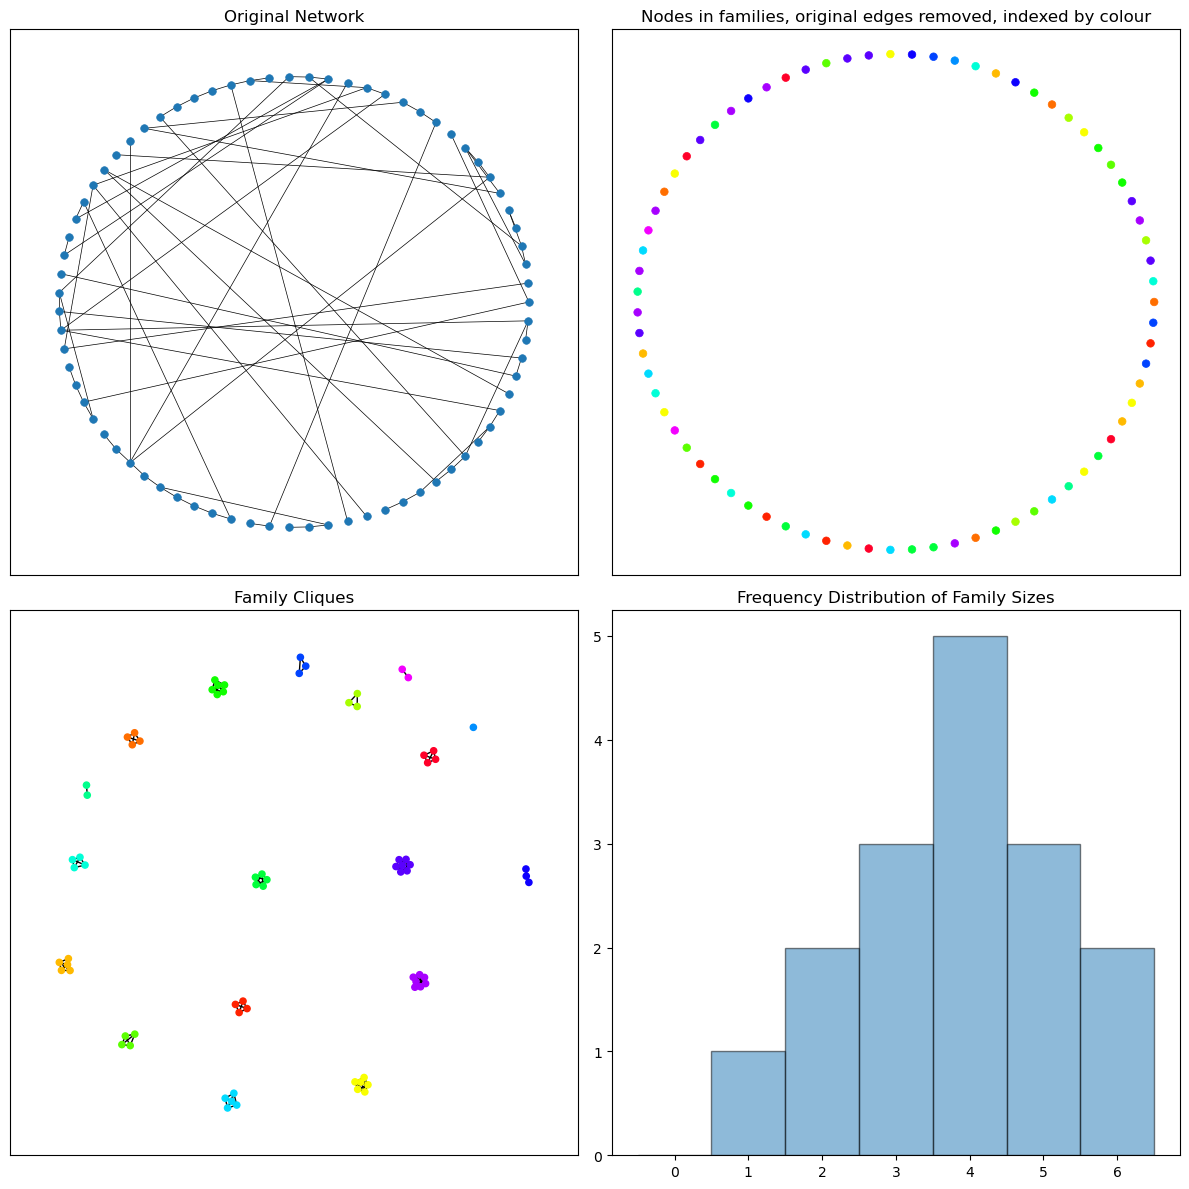


  0%|                                                     | 0/5 [00:00<?, ?it/s]

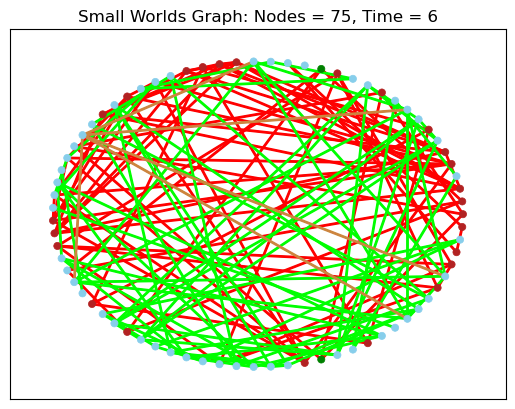


 20%|█████████                                    | 1/5 [00:00<00:00,  5.04it/s]

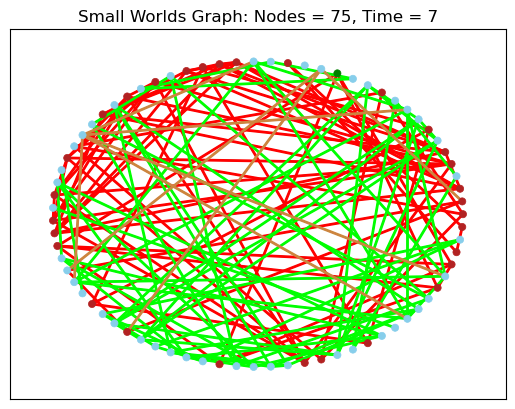


 40%|██████████████████                           | 2/5 [00:00<00:00,  6.03it/s]

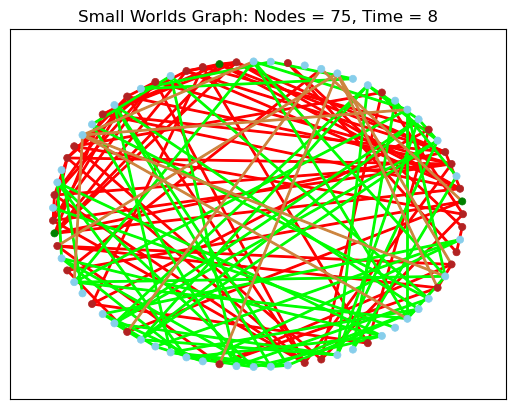


 60%|███████████████████████████                  | 3/5 [00:00<00:00,  6.51it/s]

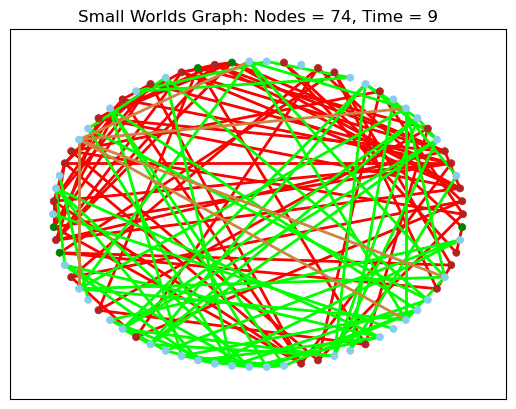


 80%|████████████████████████████████████         | 4/5 [00:00<00:00,  6.77it/s]

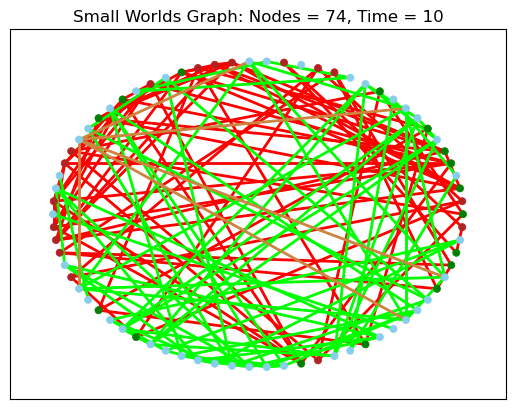


 30%|█████████████▏                              | 6/20 [00:01<00:07,  1.90it/s]

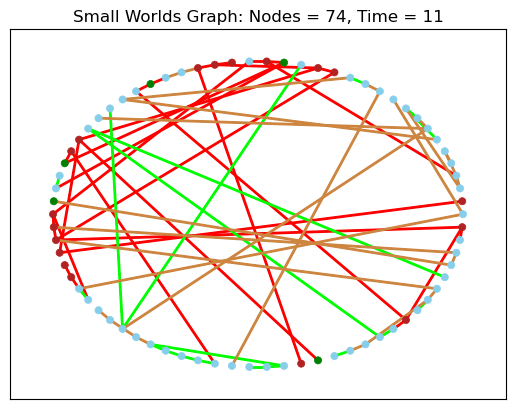

 55%|███████████████████████▋                   | 11/20 [00:02<00:01,  5.84it/s]

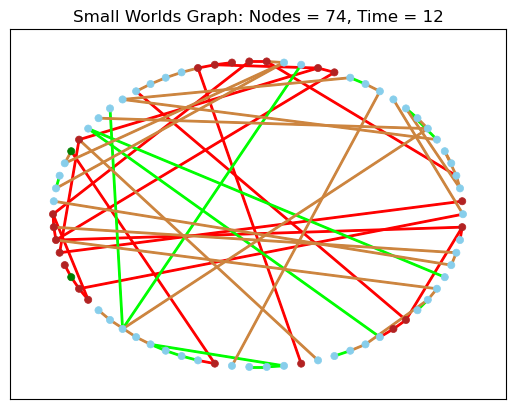

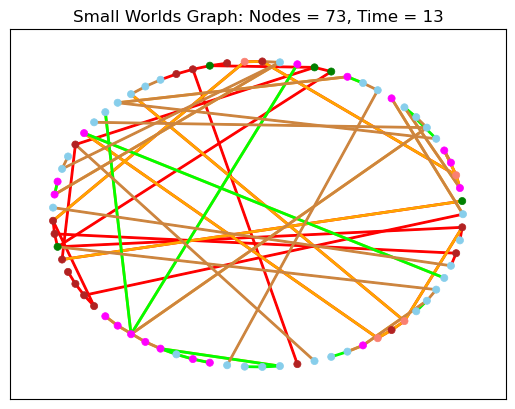

 65%|███████████████████████████▉               | 13/20 [00:02<00:01,  6.32it/s]

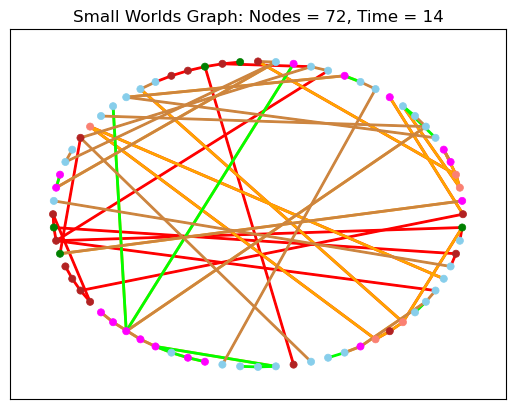

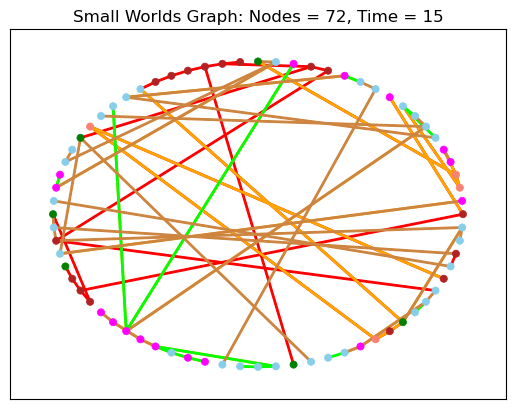

 75%|████████████████████████████████▎          | 15/20 [00:02<00:00,  6.74it/s]

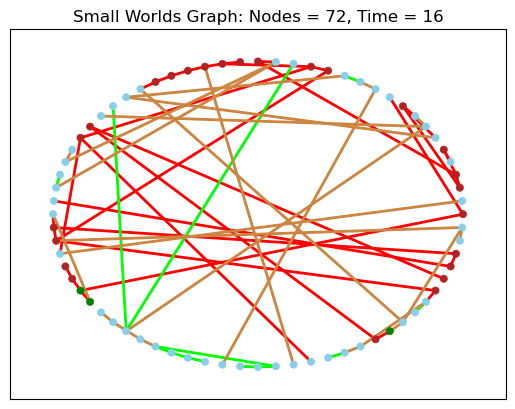

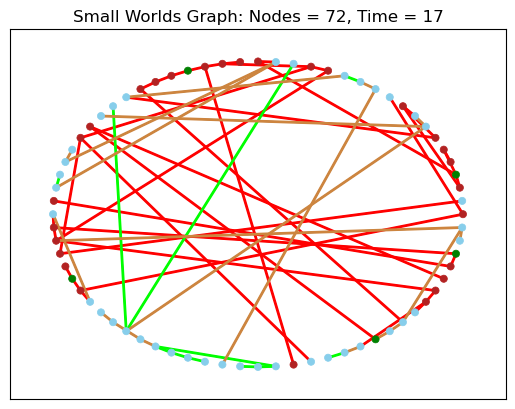

 85%|████████████████████████████████████▌      | 17/20 [00:02<00:00,  7.07it/s]

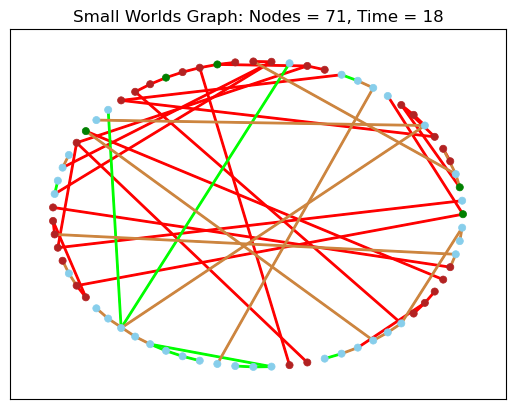

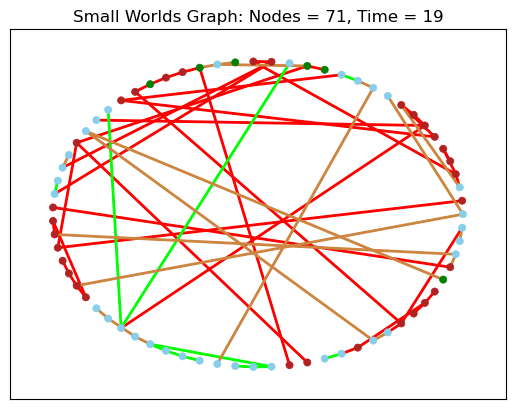

 95%|████████████████████████████████████████▊  | 19/20 [00:03<00:00,  7.36it/s]

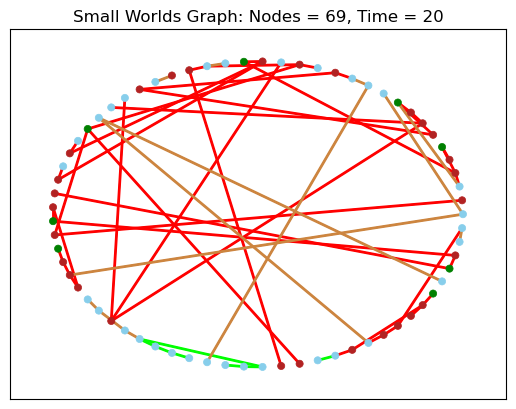

100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  6.33it/s]


In [24]:
# Implementing into propagation 

# For visualisation
def locate_family(node, family_list):
    index = None
    for i in range(len(family_list)):
        if node in family_list[i]:
            index = i
            return index
        else:
            pass
    if index == None:
        print('Node not found in family list.')

class Pandemic_Network():
    
    def __init__(self, network_type: str, nodes: int, pandemicprob: float, mitigation_info = None, NIP = 3, RP = 0, sicknode = 0, SW_connections = 3, SW_randomness = 0.5, SF_k = 1, plots = False, TTR = 15, lockdown_times = None):
        '''
        mitigation_info - list: [Proportion that mitigate, Probability of mitigation not working, Start Time, 
                                End Time]. If probability of mitigation not working is a tuple, then implement 
                                directional mitigation. The first value in tuple is for healthy and second is 
                                for infected node.
        sicknodes - number of sick nodes to begin with
        TTR - Time to recover
        RP - Reinfect Probability - probability of being susceptable to reinfection default is 0 i.e. no reinfection
        NIP - Non-Infectious Period
        '''

        if network_type == 'Ring': # default is a ring network
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = 0, seed=None)
        elif network_type == 'Small World':
            self.g = nx.watts_strogatz_graph(n = nodes, k = SW_connections, p = SW_randomness, seed=None)
        elif network_type == 'Scale Free':
            self.g = nx.barabasi_albert_graph(n = nodes, m = SF_k, seed=None, initial_graph=None) # m = Number of edges to attach from a new node to existing nodes
        else:
            self.g = nx.erdos_renyi_graph(n = nodes, p = 0.5, seed=None, directed=False) # if network type not specified, then generate random graph (erdos renyi model)

        #self.pos = nx.circular_layout(self.g)
        self.n = nodes
        self.t = 0
        self.p = pandemicprob
        self.want_plots = plots

        #Mitigations
        if mitigation_info != None:  # if mitigations
            self.mitstart = mitigation_info[2]
            self.mitend = mitigation_info[3]
            self.mitproportion = mitigation_info[0]
            if type(mitigation_info[1]) == tuple:
                self.p_effective_healthy, self.p_effective_infected = mitigation_info[1]
                self.directional = True
            else:
                self.p_effective = mitigation_info[1]
                self.directional = False
        
        self.mitigating = set([])

        # Lockdown 
        self.inlockdown = False
        if type(lockdown_times) == tuple:
            self.lockdownstart, self.lockdownend = lockdown_times
            
        else:
            self.lockdownstart, self.lockdownend = 0,0
        
        #Sick nodes
        self.sicknodes = set([random.randint(0, nodes-1) for i in range(sicknode)]) # randomly generate n number of sicknnode
        self.recovered = set([])
        self.TTR = TTR # days to recover, default is 15, customisable dependent on model
        
        #Reinfection
        self.NIP = NIP  # 
        self.RP = RP
        
        # initialise TTR
        initial_TTR_vals = [0 if i not in self.sicknodes else TTR + 1 for i in range(nodes)]
        initial_TTR_dict = {i:initial_TTR_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_TTR_dict, name = 'TTR')
        
        # initialise RP
        initial_NIP_vals = [0 if i not in self.recovered else NIP + 1 for i in range(nodes)]
        initial_NIP_dict = {i:initial_NIP_vals[i] for i in range(nodes)}
        nx.set_node_attributes(self.g, initial_NIP_dict, name = 'NIP')
        # TO Perform reinfection - just introduce a new weight to allow reinfected edges. This weight can be 
        # the probability of infection normally * the probability of reinfection
        
        #Re 
        self.R = dict()
        for node in self.sicknodes:
            self.R[node] = 0 # initialise the infected nodes to having infected 0 other nodes
        self.Rt = []
    
    def plot(self):
        self.pos = nx.circular_layout(self.g)
        node_colors = ["green" if node in self.recovered else 'salmon' if node in self.mitigating and node in self.sicknodes else 'magenta' if node in self.mitigating else "firebrick" if node in self.sicknodes else "skyblue" for node in self.g.nodes()]
        nx.draw_networkx(self.g, pos = self.pos, with_labels=False, node_size=2000/self.n, node_color=node_colors, linewidths=0.5)

        e_no_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p]
        e_mit = [(u, v) for (u, v, d) in self.g.edges(data=True) if u in self.mitigating or v in self.mitigating]
        e_sus = [(u, v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == 0]
        e_rp = [(u,v) for (u, v, d) in self.g.edges(data=True) if d["weight"] == self.p*self.RP]
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_no_mit, width=2, edge_color='red') # un-mitigating
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_mit, width=2, edge_color='orange') # mitigating
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_sus, width=2, edge_color='lime') # susceptible
        nx.draw_networkx_edges(self.g, self.pos, edgelist=e_rp, width=2, edge_color='peru') # Reinfected

        
        plt.title("Small Worlds Graph: Nodes = "+ str(len(self.g.nodes()))+ ", Time = " + str(self.t))
        plt.show()
        return
    
    
    def lockdown(self, lockdown_length: int, average_members_in_family = 4, lockdown_popgrowth = 0, lockdown_fatalityrate = 0, plot = False):
        self.num_fam = int(self.n/average_members_in_family)
        
        if lockdown_length == 0:
            return
        
        if plot: 
            
            #Plot original network 
            plt.figure(figsize=(12,12))
            plt.subplot(221)
            pos = nx.circular_layout(self.g)
            nx.draw_networkx(self.g, pos = pos, with_labels=False, node_size=30, node_color='tab:blue', linewidths=0.5, width = 0.5)
            plt.title('Original Network')
        

        # Identify and remove all original existing edges
        edges = list(self.g.edges) 
        originaledges = copy.deepcopy(edges)
        for i in range(len(list(self.g.edges))):
            self.g.remove_edge(u = edges[i][0], v = edges[i][1])
        
        # Group nodes into random clusters
        families = [[] for i in range(self.num_fam)]
        dummy_nodes_list = list(self.g.nodes)

        while len(dummy_nodes_list) > 0:
            fam_index = random.randint(0, self.num_fam-1)
            families[fam_index].append(dummy_nodes_list[-1])
            dummy_nodes_list.remove(dummy_nodes_list[-1])
        
        if plot: 
            # Colour-coding and plot colour coded nodes based on family index
            nodes = list(self.g.nodes)
            familymap = [locate_family(i, families) for i in nodes]
            colormap = [cm.gist_rainbow(i/self.num_fam) for i in familymap]
            plt.subplot(222)
            nx.draw_networkx(self.g, pos = pos, with_labels=False, node_size=30, node_color=colormap, linewidths=0.5, width = 0.5)
            plt.title('Nodes in families, original edges removed, indexed by colour')


        for i in families:
            pairs = list(itertools.combinations(i, 2)) # all combinations, list of edges to generate clique in a family
            # print(families.index(i))
            for p in pairs:
                # print(p)
                self.g.add_edge(p[0], p[1]) # add all edges in each family clique, all nodes are connected to each other in the clique

        if plot: 
            plt.subplot(223)
            nx.draw_networkx(self.g, with_labels=False, node_size=20, node_color=colormap, linewidths=1, width = 1)
            plt.title('Family Cliques')
            
        # Determing frequency of family sizes 
        family_sizes = [len(i) for i in families]

        if plot:
            plt.subplot(224)
            plt.hist(x = family_sizes, bins = [i-0.5 for i in range(max(family_sizes)+1)], edgecolor = "black", alpha = 0.5, align = 'mid')
            plt.title('Frequency Distribution of Family Sizes')

            plt.tight_layout()
            plt.show()
            
        # Propagating in lockdown
        self.inlockdown = True   # so that timestep isn't skipped if timestep == lockdownstart time
        lockdowntime, lockdowninfected, lockdownrecovered, lockdownuninfected, lockdowncum, lockdownRe = \
                                                            self.propagate(lockdown_length, lockdown_popgrowth, 
                                                                           lockdown_fatalityrate)
        self.inlockdown = False
        
        # Restoring to original graph
        edges = list(self.g.edges) 
        for i in range(len(edges)):
            self.g.remove_edge(u = edges[i][0], v = edges[i][1])
            
        nodes = list(self.g.nodes)
        for u,v in originaledges:
            if u in nodes and v in nodes:
                self.g.add_edge(u, v)
            
        return 
            
        
                
    #def sicknode
    def propagate(self, steps: int, populationgrowth = 0, fatalityrate = 0):
        growthrate = populationgrowth/steps
        self.fatalityprob = fatalityrate/self.TTR
        self.newnodes = growthrate*self.n    # number of new nodes to add each step
        nodecounter = self.n
        
        uniquesick = set()
        for node in self.sicknodes:
            uniquesick.add(node)
            
        if self.directional:
            self.timestamps = []
            self.infectious_count = []
            self.recovery_count = []
            self.uninfected_count = []
            self.cumulative_case_count = []

            for time in tqdm.tqdm(range(steps)):
                # Adding new nodes
                for i in range(int(self.newnodes)):
                    label = nodecounter
                    self.g.add_node(label)
                    nx.set_node_attributes(self.g, {label:0}, name = 'TTR')
                    nx.set_node_attributes(self.g, {label:0}, name = 'NIP')
                    
                    #Check if new node should be mitigating
                    if random.random() < self.mitproportion and time < self.mitend and time > self.mitstart:
                        self.mitigating.add(label)
                    
                    #Check if new node has any edges with a sick node
                    neighbours = list(self.g.neighbors(label))
                    for j in neighbours:
                        if j in self.sicknodes:
                            if j in self.mitigating:
                                self.g.add_edge(label, j, weight = self.p*self.p_effective_infected)
                                
                            elif label in self.mitigating:
                                self.g.add_edge(label, j, weight = self.p*self.p_effective_healthy)
                            
                            else:
                                self.g.add_edge(label, j, weight = self.p)
                    nodecounter += 1
                    
                    
                #check sick nodes
                new_sick = 0
                self.timestamps.append(time)
                # print('Time = ', time)
                # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
                # print('Infectious:', self.sicknodes)
                # print('Recovered:', self.recovered)
                if time == 0:
                    self.cumulative_case_count.append(len(self.sicknodes))

                    # initialise edge weights
                    edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                    for j in edge_list:
                        if (j[0] in self.sicknodes or j[1] in self.sicknodes):
                            self.g.add_edge(j[0], j[1], weight = self.p) 
                        else:
                            self.g.add_edge(j[0], j[1], weight = 0) 

                if time == self.lockdownstart and self.inlockdown == False:
                    self.lockdown(self.lockdownend-self.lockdownstart, lockdown_popgrowth = 0, 
                                  lockdown_fatalityrate = fatalityrate, plot = self.plot)
                    continue # Call lockdown then move onto next time step
                    
                if time > self.lockdownstart and time < self.lockdownend and self.inlockdown == False:
                    continue # if time has already passed in lockdown
                    
                if time == self.lockdownend and self.inlockdown == False:
                    # initialise edge weights
                    edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                    for j in edge_list:
                        if (j[0] in self.sicknodes or j[1] in self.sicknodes):
                            self.g.add_edge(j[0], j[1], weight = self.p) 
                        else:
                            self.g.add_edge(j[0], j[1], weight = 0) 

                if time == self.mitstart:
                    while len(self.mitigating) < int(self.n*self.mitproportion):
                        self.mitigating.add(random.choice(list(self.g.nodes())))

                if time == self.mitend:
                    self.mitigating = []

                self.infectious_count.append(len(self.sicknodes))
                self.recovery_count.append(len(self.recovered))
                self.uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))

                currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones

                for i in list(self.g.nodes):

                    #Checking TTR
                    if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                        self.sicknodes.remove(i)
                        self.recovered.add(i)
                        nx.set_node_attributes(self.g, {i:self.NIP + 1}, name = 'NIP') # initialise infectious node
                        nx.set_node_attributes(self.g, {i: 0}, name='TTR') # decrement TTR value

                    elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                        pass
                    else: # mid infectious period
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value    

                    #Checking NIP
                    if self.g.nodes[i]['NIP'] -1 == 0:
                        self.recovered.remove(i)
                        neighbours = list(self.g.neighbors(i))
                        for n in neighbours:
                            self.g.add_edge(i, n, weight = self.RP*self.p)  # after infection, new weights should be probability of infection * probability of reinfection

                        #if i in self.mitigating:
                        #    self.mitigating.remove(i)
                        #else:
                        #    pass
                        nx.set_node_attributes(self.g, {i: 0}, name='NIP') # decrement TTR value

                    elif self.g.nodes[i]['NIP'] == 0: # not non-infectious period, no action
                        pass
                    else:
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['NIP'] - 1}, name='NIP') # decrement TTR value    


                for node in currentsick:
                    # Check if node should be removed i.e. it dies
                    if random.random() < self.fatalityprob:  
                        self.g.remove_node(node) # remove node from graph
                        if node in self.sicknodes: # if node hasn't already recovered
                            self.sicknodes.remove(node) # remove node from sicknodes
                        continue # move on to new node
                    
                    neighbours = list(self.g.neighbors(node))
                    #try to propagate sickness
                    for neighbour in neighbours:
                        if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick.
                            pass
                        elif node in self.mitigating:
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']*self.p_effective_infected: # infected node mitigating
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                
                                if neighbour not in uniquesick:
                                    new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                        self.g.add_edge(i, neighbour, weight = self.p)

                        elif neighbour in self.mitigating: # node did not adopt mitigation measure 
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']*self.p_effective_healthy: # healthy node mitigating
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                
                                if neighbour not in uniquesick:
                                    new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                        self.g.add_edge(i, neighbour, weight = self.p)
                        else: 
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']:  # no node mitigating
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                
                                if neighbour not in uniquesick:
                                    new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                        self.g.add_edge(i, neighbour, weight = self.p)

                self.Rt.append((new_sick/len(currentsick))*5) # Can just calculate Rt using this as it is just ratio of new people infected with currently infected nodes
                self.cumulative_case_count.append(self.cumulative_case_count[-1] + new_sick)
                self.t += 1 #timestep increase by 1

                if self.want_plots: 
                    self.plot()


                #If no more sick nodes than we can finish propagation
                if len(self.sicknodes) == 0:
                    break
                    
        else: # if not directed mitigation probability of effectiveness
            self.timestamps = []
            self.infectious_count = []
            self.recovery_count = []
            self.uninfected_count = []
            self.cumulative_case_count = []
            # Adding new nodes
            for i in range(int(self.newnodes)):
                label = nodecounter
                self.g.add_node(label)
                nx.set_node_attributes(self.g, {label:0}, name = 'TTR')
                nx.set_node_attributes(self.g, {label:0}, name = 'NIP')
                
                #Check if new node should be mitigating
                if random.random() < self.mitproportion and time < self.mitend and time > self.mitstart:
                    self.mitigating.add(label)
                    
                #Check if new node has any edges with a sick node
                neighbours = list(self.g.neighbors(label))
                for j in neighbours:
                    if j in self.sicknodes:
                        if j in self.mitigating or label in self.mitigating:
                            self.g.add_edge(label, j, weight = self.p*self.p_effective)
                                
                        else:
                            self.g.add_edge(label, j, weight = self.p)
                    nodecounter += 1
                    
            for time in tqdm.tqdm(range(steps)):
                #check sick nodes
                new_sick = 0
                self.timestamps.append(time)
                # print('Time = ', time)
                # print([self.g.nodes[i]['TTR'] for i in range(len(list(self.g.nodes)))])
                # print('Infectious:', self.sicknodes)
                # print('Recovered:', self.recovered)
                if time == 0:
                    self.cumulative_case_count.append(len(self.sicknodes))

                    # initialise edge weights
                    edge_list = [(u, v) for (u, v, d) in self.g.edges(data = True)] # all edges
                    for j in edge_list:
                        if (j[0] in self.sicknodes or j[1] in self.sicknodes):
                            self.g.add_edge(j[0], j[1], weight = self.p) 
                        else:
                            self.g.add_edge(j[0], j[1], weight = 0) 

                    # self.plot()

                else: 
                    pass

                if time == self.mitstart:
                    while len(self.mitigating) < int(self.n*self.mitproportion):
                        self.mitigating.add(random.choice(list(self.g.nodes())))

                if time == self.mitend:
                    self.mitigating = []

                self.infectious_count.append(len(self.sicknodes))
                self.recovery_count.append(len(self.recovered))
                self.uninfected_count.append(self.n - len(self.recovered) - len(self.sicknodes))

                currentsick = copy.copy(self.sicknodes) #as new sick nodes may be created and we don't want to loop through the new ones

                for i in range(len(list(self.g.nodes))):

                    #Checking TTR
                    if self.g.nodes[i]['TTR'] - 1 == 0: # end of infectious period
                        self.sicknodes.remove(i)
                        self.recovered.add(i)
                        nx.set_node_attributes(self.g, {i:self.NIP + 1}, name = 'NIP') # initialise infectious node
                        nx.set_node_attributes(self.g, {i: 0}, name='TTR') # decrement TTR value

                    elif self.g.nodes[i]['TTR'] == 0: # not infectious, no action
                        pass
                    else: # mid infectious period
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['TTR'] - 1}, name='TTR') # decrement TTR value    

                    #Checking NIP
                    if self.g.nodes[i]['NIP'] -1 == 0:
                        self.recovered.remove(i)
                        neighbours = list(self.g.neighbors(i))
                        for n in neighbours:
                            self.g.add_edge(i, n, weight = self.RP*self.p)  # after infection, new weights should be probability of infection * probability of reinfection

                        #if i in self.mitigating:
                        #    self.mitigating.remove(i)
                        #else:
                        #    pass
                        nx.set_node_attributes(self.g, {i: 0}, name='NIP') # decrement TTR value

                    elif self.g.nodes[i]['NIP'] == 0: # not non-infectious period, no action
                        pass
                    else:
                        nx.set_node_attributes(self.g, {i: self.g.nodes[i]['NIP'] - 1}, name='NIP') # decrement TTR value    


                for node in currentsick:
                    # Check if node should be removed i.e. it dies
                    if random.random() < self.fatalityprob:  
                        self.g.remove_node(node) # remove node from graph
                        self.sicknodes.remove(node) # remove node from sicknodes
                        continue # move on to new node
                    
                    neighbours = list(self.g.neighbors(node))

                    #try to propagate sickness
                    for neighbour in neighbours:

                        if neighbour in self.sicknodes or neighbour in self.recovered: # do not infect again if already sick.
                            pass
                        elif node in self.mitigating or neighbour in self.mitigating:
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']*self.p_effective: # new node infected
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                if neighbour not in uniquesick:
                                    new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                    self.g.add_edge(i, neighbour, weight = self.p)

                        else: # node not infected
                            if np.random.random() < self.g.get_edge_data(node,neighbour)['weight']: # new node infected
                                self.sicknodes.add(neighbour)
                                adj_neighbours = list(self.g.neighbors(neighbour)) # access the neighbours of the newly infected node to create new edge weightings.
                                if neighbour not in uniquesick:
                                    new_sick += 1

                                nx.set_node_attributes(self.g, {neighbour:self.TTR + 1}, name = 'TTR') # initialise infectious node

                                for i in adj_neighbours:    
                                    self.g.add_edge(i, neighbour, weight = self.p)

                self.Rt.append((new_sick/len(currentsick))*5) # Can just calculate Rt using this as it is just ratio of new people infected with currently infected nodes
                self.cumulative_case_count.append(self.cumulative_case_count[-1] + new_sick)
                self.t += 1 #timestep increase by 1

                if self.want_plots: 
                    self.plot()


                #If no more sick nodes than we can finish propagation
                if len(self.sicknodes) == 0:
                    break
                
        # self.plot()             
        return self.timestamps, self.infectious_count, self.recovery_count, self.uninfected_count, self.cumulative_case_count[:-1], self.Rt
    
    
# Testing the class
num_nodes = 75
num_sick = 2
avg_connection = 3
randomness = 0.5
TTR_val = 3
NIP = 1
RP = 0.5
p = 0.6
mitigation = [0.3, (0.8, 0.5), 12, 15]
RP = 0.5
ntype = 'Small World'
populationgrowth = 0.15
fatalityrate = 0.05
lockdowndates = (5,10)

G_data = Pandemic_Network(network_type = ntype, nodes = num_nodes, pandemicprob = p, mitigation_info = mitigation, 
                          NIP = NIP, RP = RP, sicknode = 1, SW_connections = avg_connection, 
                          SW_randomness = randomness, plots = True, TTR = TTR_val, 
                          lockdown_times = lockdowndates).propagate(20, populationgrowth, fatalityrate)
